## Assessment of study-dataset splitting

<b>source:</b> "https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/notebooks/1_building_and_annotating_the_atlas_core/01b_study_splitting_by_batch_effect_assessment.ipynb"

In this notebook we will determine which of the studies that have substantial differences in experimental conditions within study will need to be split into separate datasets (datasets will be the "batches" used for integration).

### Import modules

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
def check_if_nan(value):
    """return Boolean version of value that is True if value is
    some type of NaN (e.g. np.nan, None, "nan" etc). 
    Example use:
    none_entries = subadata.obs.applymap(check_if_nan)
    subadata.obs = subadata.obs.mask(none_entries.values)
    """
    if value == "nan":
        return True
    elif value == None:
        return True
    if isinstance(value, float):
        if np.isnan(value):
            return True
    if value == "ND":
        return True
    return False

### Set paths:

In [5]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/home/h/hollenberg/MaPra/merged_data.h5ad"
# path to results directory:
dir_out = "/home/h/hollenberg/MaPra"

### Perpare groups to check batch effect

In [6]:
adata = sc.read(adata_path)

In [7]:
keywords = ['misharin', 'tsukui', 'schiller', 'peyser', 'xie']

# get project information
for idx, row in adata.obs.iterrows():
    string_value = row['batch']
    for keyword in keywords:
        if keyword in string_value:
            adata.obs.at[idx, 'project'] = keyword
            break

In [8]:
adata.obs.project.unique()

array(['xie', 'peyser', 'tsukui', 'misharin', 'schiller'], dtype=object)

In [9]:
adata.obs.condition.unique()

['untreated', 'bleomycin', 'saline', 'nintedanib', 'asbestos']
Categories (5, object): ['untreated', 'asbestos', 'bleomycin', 'nintedanib', 'saline']

In [15]:
# combination of batch and project doesen't add add information -> useless
#adata.obs['project-batch'] = adata.obs['project'].astype(str).str.cat(adata.obs['batch'].astype(str), sep='-')
adata.obs['project-annotation'] = adata.obs['project'].astype(str).str.cat(adata.obs['manual_celltype_annotation'].astype(str), sep='-')
adata.obs['batch-annotation'] = adata.obs['batch'].astype(str).str.cat(adata.obs['manual_celltype_annotation'].astype(str), sep='-')

In [17]:
adata.obs

,author_annotation,scDblFinder_score,scDblFinder_class,manual_celltype_annotation,batch,condition,doublet_score,predicted_doublet,timepoint,author_annotation_coarse,...,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,low_hierarchy,high_hierarchy,project,project-batch,project-annotation,batch-annotation
AAACCTGAGGACATTA-1_xie,Col13a1,0.021293,singlet,Myofibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Adventitial fibroblasts ∈ Myofibroblasts ∈ Myo...,Group1,xie,xie-1_xie,xie-Myofibroblasts,1_xie-Myofibroblasts
AAACCTGCAGTCGTGC-1_xie,Myofibroblasts,0.000934,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,xie,xie-1_xie,xie-Peribronchial fibroblasts,1_xie-Peribronchial fibroblasts
AAACCTGCATGAAGTA-1_xie,Lipofibroblasts,0.000118,singlet,Alveolar macrophages,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,UNRESOLVED = Alveolar macrophages = Alveolar m...,Group16,xie,xie-1_xie,xie-Alveolar macrophages,1_xie-Alveolar macrophages
AAACCTGTCTCGCATC-1_xie,Myofibroblasts,0.000478,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,xie,xie-1_xie,xie-Peribronchial fibroblasts,1_xie-Peribronchial fibroblasts
AAACGGGTCCTAGAAC-1_xie,Myofibroblasts,0.000669,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,Peribronchial fibroblasts = Peribronchial fibr...,Group13,xie,xie-1_xie,xie-Peribronchial fibroblasts,1_xie-Peribronchial fibroblasts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29291_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblasts,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,...,0.0,0.0,0.0,0.0,UNRESOLVED = UNRESOLVED = UNRESOLVED = UNRESOL...,Group20,schiller,schiller-muc4657_schiller,schiller-Alveolar fibroblasts,muc4657_schiller-Alveolar fibroblasts
29292_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,...,0.0,0.0,0.0,0.0,Epithelial = AT2 = AT2 ∈ Epithelial = AT2,Group7,schiller,schiller-muc4657_schiller,schiller-AT2,muc4657_schiller-AT2
29293_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblasts,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,...,0.0,0.0,0.0,0.0,UNRESOLVED = UNRESOLVED = UNRESOLVED = UNRESOL...,Group20,schiller,schiller-muc4657_schiller,schiller-Alveolar fibroblasts,muc4657_schiller-Alveolar fibroblasts
29294_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,...,0.0,0.0,0.0,0.0,Epithelial = AT2 = AT2 ∈ Epithelial = AT2,Group7,schiller,schiller-muc4657_schiller,schiller-AT2,muc4657_schiller-AT2


specifiy covariates we want to check (we will quantify their correlation with the 1st 50 PCs, to see how much variance they can each explain):

In [18]:
covariates = [
    "project", # ['xie', 'peyser', 'tsukui', 'misharin', 'schiller']
    "batch", # ['0_misharin', '0_tsukui', '1_misharin', '1_tsukui', ...,]
    "condition", # ['untreated', 'asbestos', 'bleomycin', 'nintedanib', 'saline']
    "manual_celltype_annotation",
    "project-annotation",
    "batch-annotation"
]

Create shuffled assignment of single cell platform (and processing site if included), to compare actual variance explained to variance explained expected by random. We will assign all cells of the same sample to the same value.

In [19]:
# create shuffled version of single cell platform, and of Processing_site:
sample_to_scplatform = adata.obs.groupby("batch").agg({"project": "first"})

for i in range(10):
    np.random.shuffle(sample_to_scplatform.project)
    adata.obs["shuffled_project_" + str(i)] = adata.obs["batch"].map(
        dict(
            zip(
                sample_to_scplatform.index,
                sample_to_scplatform.project,
            )
        )
    )
    covariates.append("shuffled_project_" + str(i))

/tmp/user/20166/ipykernel_777426/74698311.py:5: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_scplatform.project)
/tmp/user/20166/ipykernel_777426/74698311.py:5: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_scplatform.project)
/tmp/user/20166/ipykernel_777426/74698311.py:5: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(sample_to_scplatform.project)
/tmp

In [20]:
n_pcs = 50

Now check for every covariate, for every PC how much variance among the cells' PC scores the covariate can explain. Add this variance explained per PC up across PCs for every covariate. This will give us the total amount of variance explained per covariate.

In [21]:
var_explained = pd.DataFrame(index=range(n_pcs), columns=covariates + ["overall"])
for pc in range(n_pcs):
    y_true_unfiltered = adata.obsm["X_pca"][:, pc]
    var_explained.loc[pc, "overall"] = np.var(y_true_unfiltered)
    for cov in covariates:
        x = adata.obs[cov].values.copy()
        x_nans = np.vectorize(check_if_nan)(x)
        x = x[~x_nans]
        if len(x) != 0:
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
            else:
                if len(set(x)) == 1:
                    var_explained.loc[pc, cov] = np.nan
                    continue
                x = pd.get_dummies(x)
            lrf = LinearRegression(fit_intercept=True).fit(
                x,
                y_true,
            )
            y_pred = lrf.predict(x)
            var_explained.loc[pc, cov] = np.var(y_pred)
total_variance_explained = np.sum(var_explained, axis=0).sort_values(ascending=False)
total_variance_explained_fractions = (
    total_variance_explained / total_variance_explained["overall"]
)

In [22]:
var_explained

,project,batch,condition,manual_celltype_annotation,project-annotation,batch-annotation,shuffled_project_0,shuffled_project_1,shuffled_project_2,shuffled_project_3,shuffled_project_4,shuffled_project_5,shuffled_project_6,shuffled_project_7,shuffled_project_8,shuffled_project_9,overall
0,11.92465,22.109715,0.688915,22.232833,34.568027,35.523756,0.600342,2.824316,1.432044,13.034613,7.585993,0.916004,4.656527,1.712647,2.555795,2.018489,40.038292
1,6.170529,8.066975,2.748012,13.467031,17.616099,18.375973,0.879927,1.328067,0.767443,0.41044,0.25473,0.544855,0.553186,0.847363,1.411449,0.573117,23.579906
2,1.385633,2.314362,1.531167,10.214559,13.366697,13.886172,0.126355,0.457933,0.064844,0.694716,0.122495,0.050264,0.951626,0.743216,1.101336,0.046688,16.509029
3,1.134595,1.738168,0.382597,9.761434,11.350805,11.501603,0.076224,0.098359,0.081091,0.270821,0.331275,0.607107,0.363774,0.16799,0.408609,0.143821,13.543835
4,0.260231,0.831458,0.032446,3.848627,4.963551,5.323917,0.073066,0.224168,0.054091,0.032489,0.025982,0.114584,0.123099,0.021141,0.01405,0.055138,7.241051
5,0.669936,1.474984,0.467455,3.312379,4.227685,4.671118,0.115483,0.145679,0.222927,0.207104,0.23189,0.027361,0.002566,0.193345,0.238968,0.031118,6.026707
6,0.157289,0.441548,0.078226,2.003004,2.518307,2.827184,0.032072,0.089572,0.063073,0.061659,0.011097,0.045451,0.063202,0.057518,0.014331,0.16352,4.601632
7,0.29728,0.53715,0.254345,2.002425,2.455764,2.662547,0.009594,0.105022,0.030645,0.075004,0.076526,0.030152,0.101837,0.096154,0.051919,0.029434,3.941306
8,0.022968,0.284572,0.041834,1.606178,1.856584,2.066937,0.047139,0.047064,0.015689,0.084671,0.042118,0.058825,0.01285,0.008734,0.041019,0.028698,3.313376
9,0.139166,0.304945,0.01853,1.459025,1.928381,2.085626,0.012242,0.103761,0.012938,0.015097,0.021492,0.009605,0.042562,0.053893,0.017087,0.050565,3.03785


Do the same for the shuffled covariates. Calculate mean over shuffling instances, add as one value to clean fractions:

In [23]:
total_variance_explained_clean = total_variance_explained_fractions[
    [
        x
        for x in total_variance_explained_fractions.index
        if not x.startswith("shuffled_project")
    ]
]
total_variance_explained_clean["shuffled_project"] = np.mean(
    total_variance_explained_fractions[
        [
            x
            for x in total_variance_explained_fractions.index
            if x.startswith("shuffled_project_")
        ]
    ]
)
stdev_single_cell_platform_shuffled = np.std(
    total_variance_explained_fractions[
        [
            x
            for x in total_variance_explained_fractions.index
            if x.startswith("shuffled_project_")
        ]
    ]
)

Sort results:

In [24]:
total_variance_explained_clean.sort_values(ascending=False, inplace=True)

In [39]:
total_variance_explained_clean

overall                            1.0
batch-annotation              0.732008
project-annotation            0.689964
manual_celltype_annotation    0.494596
batch                         0.267586
project                       0.153771
condition                     0.046761
shuffled_project              0.038564
dtype: object

Plot:

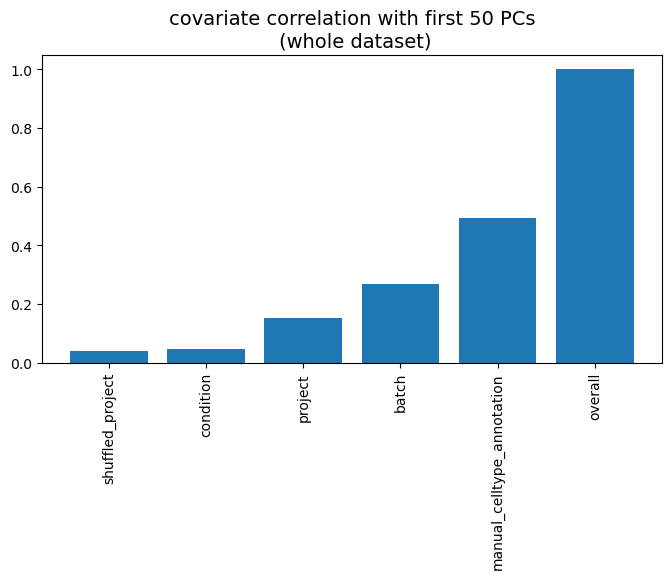

In [38]:
total_variance_explained_clean_sub = total_variance_explained_clean.drop(['batch-annotation', 'project-annotation'])
plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained_clean_sub[::-1].index,
    total_variance_explained_clean_sub[::-1].values,
)
plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)  # \n({dominant_type})
plt.xticks(rotation=90)
plt.show()

Add Combinations: batch-annotation and project-annotation

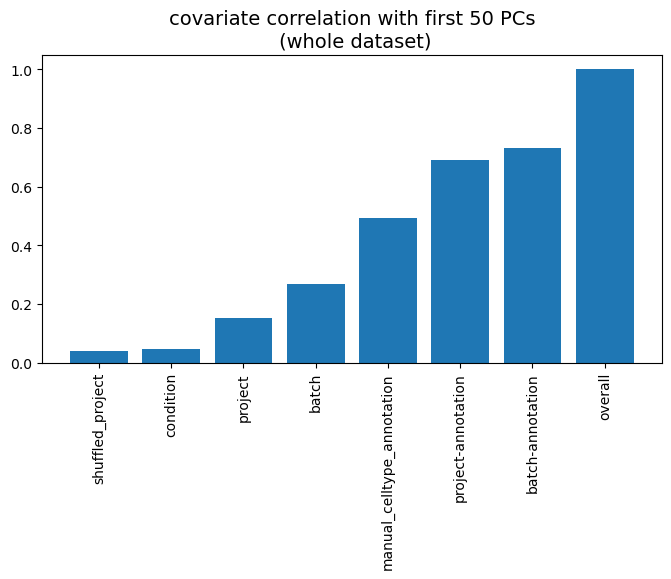

In [41]:
plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained_clean[::-1].index,
    total_variance_explained_clean[::-1].values,
)
plt.title(
    "covariate correlation with first 50 PCs\n (whole dataset)",
    fontsize=14,
)  # \n({dominant_type})
plt.xticks(rotation=90)
plt.show()

### Store results:

In [42]:
res = pd.DataFrame(total_variance_explained_clean)
res.columns = ["fraction_of_variance_explained"]
res.loc["shuffled_project", "stdev"] = stdev_single_cell_platform_shuffled

In [43]:
res.to_csv(
    f"{dir_out}/variance_explained_per_covariate.csv"
)

print z-score:

In [44]:
(
    res.loc["project", "fraction_of_variance_explained"]
    - res.loc["shuffled_project", "fraction_of_variance_explained"]
) / res.loc["shuffled_project", "stdev"]

4.740793166812156